c:\Users\Chris\OneDrive\2023\BME_M2\STAGE\Thesis\Scripts_and_venv\internship_M2\packageMyocardial.py:10: SyntaxWarning: invalid escape sequence '\c'
  base_path = f"D:\copyRaw\Rabbit_AGUIX_{rabbit}"
c:\Users\Chris\OneDrive\2023\BME_M2\STAGE\Thesis\Scripts_and_venv\internship_M2\packageMyocardial.py:25: SyntaxWarning: invalid escape sequence '\k'
  suffix = "Spectral\k_gadolinium" if kedge else "Conventional"


Available directories:
0: 2021_01_20.4511.300.2023_02_07.Rabbit_Aguix_4511_a00000

Path to DICOM files: D:\copyRaw\Rabbit_AGUIX_2\2021_01_20.4511.300.2023_02_07.Rabbit_Aguix_4511_a00000\Conventional
Total DICOM files found: 480


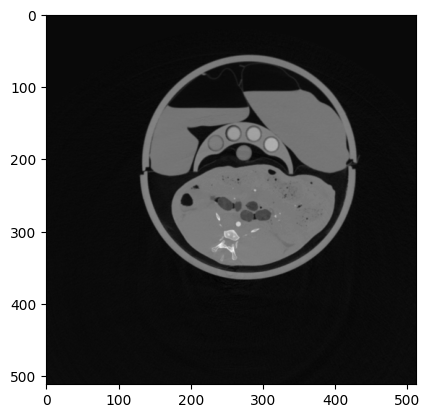

Available directories:
0: 2021_01_20.4511.300.2023_02_07.Rabbit_Aguix_4511_a00000

Path to DICOM files: D:\copyRaw\Rabbit_AGUIX_2\2021_01_20.4511.300.2023_02_07.Rabbit_Aguix_4511_a00000\Conventional
Total DICOM files found: 480
Available directories:
0: 2021_01_20.4511.300.2023_02_07.Rabbit_Aguix_4511_a00000

Path to DICOM files: D:\copyRaw\Rabbit_AGUIX_2\2021_01_20.4511.300.2023_02_07.Rabbit_Aguix_4511_a00000\Spectral\k_gadolinium
Total DICOM files found: 480


In [1]:
from packageMyocardial import rawCopyLoader
import matplotlib.pyplot as plt

#Load conventional and k-edge samples
conventional_sample = load3dStack(2, False)
kedge_sample = load3dStack(2, True)

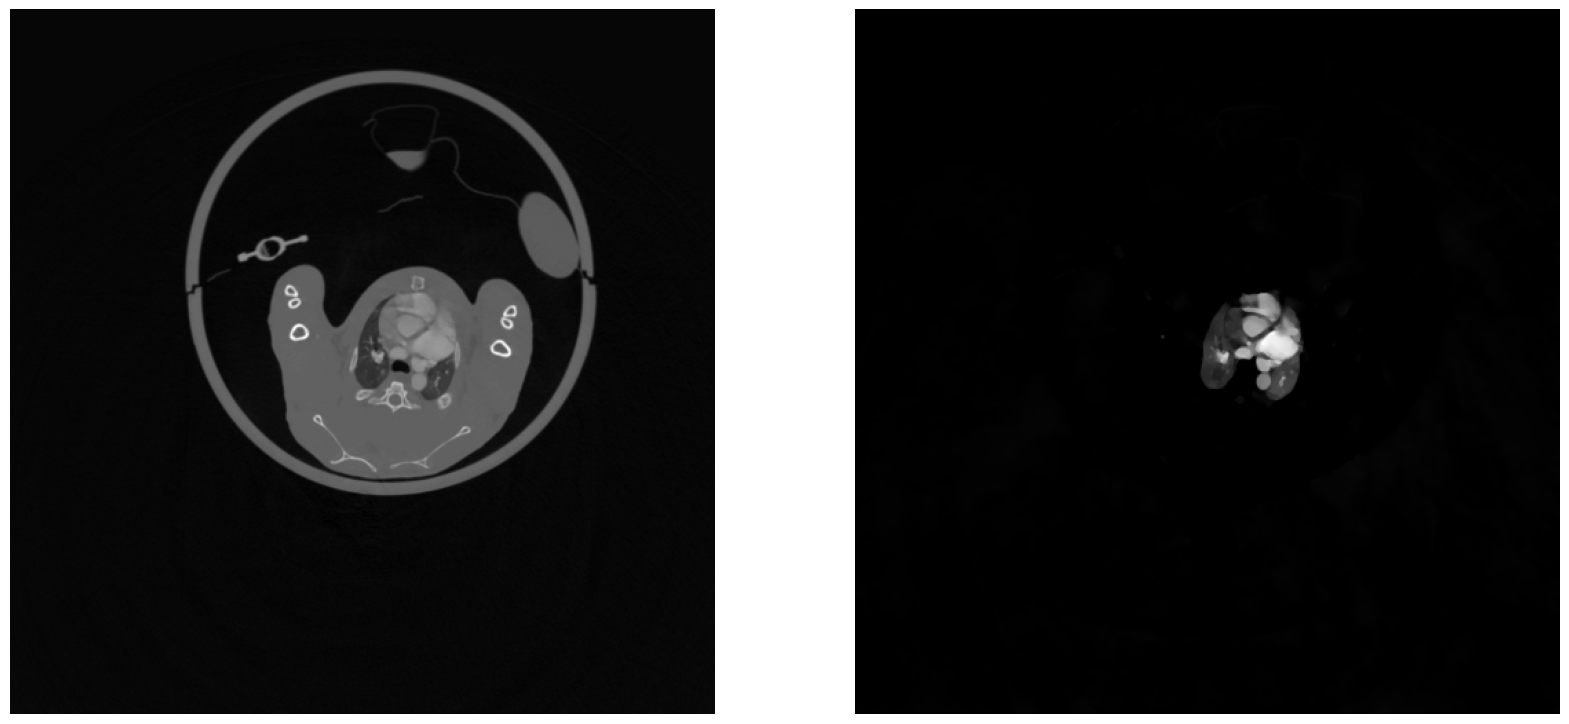

In [7]:
# Display one slice
n = 400
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(conventional_sample[:, :, n], cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(kedge_sample[:,:,n], cmap = 'gray')
plt.axis('off')
plt.show()

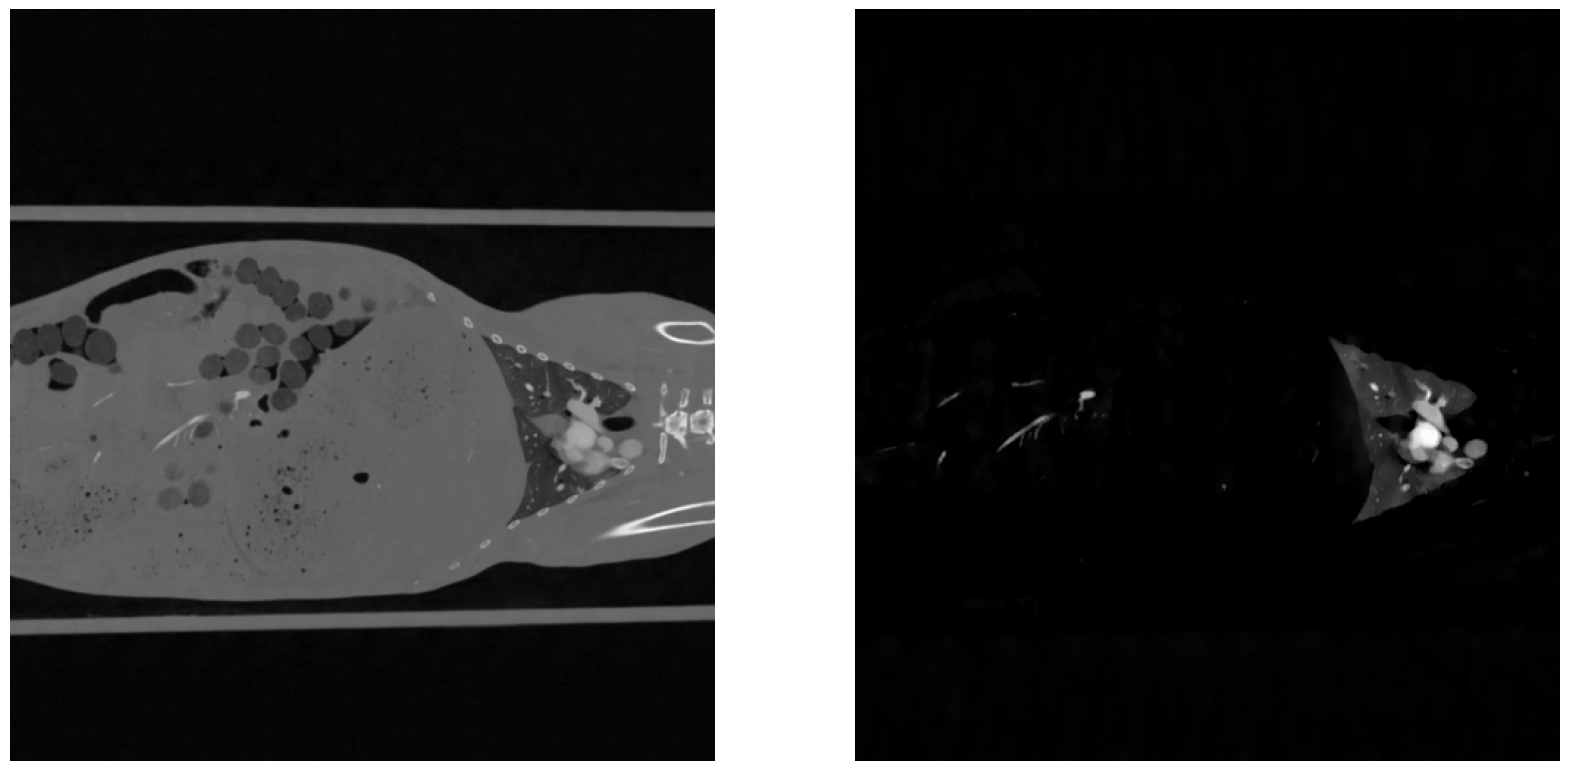

In [ ]:
# Display one slice
n = 253
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(conventional_sample[n, :, :], cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(kedge_sample[n,:,:], cmap = 'gray')
plt.axis('off')
plt.show()

In [17]:
from SPCCT_4D import Sample, Timepoint
s1 = Sample(1)
s2 = Sample(2)

Available directories:
0: 2021_01_20.4511.400.2023_09_30.Rabbit_Aguix_4511_b00000
1: 2021_01_20.4511.500.2023_09_30.Rabbit_Aguix_4511_b00001
2: 2021_01_20.4511.600.2023_09_30.Rabbit_Aguix_4511_b00002
3: 2021_01_20.4511.700.2023_09_30.Rabbit_Aguix_4511_b00003
Total DICOM files found: 480
Total DICOM files found: 480
Total DICOM files found: 480
Total DICOM files found: 480
Total DICOM files found: 480
Total DICOM files found: 480
Total DICOM files found: 480
Total DICOM files found: 480
Available directories:
0: 2021_01_20.4511.300.2023_02_07.Rabbit_Aguix_4511_a00000
Total DICOM files found: 480
Total DICOM files found: 480


(512, 512, 480)


(-0.5, 479.5, 511.5, -0.5)

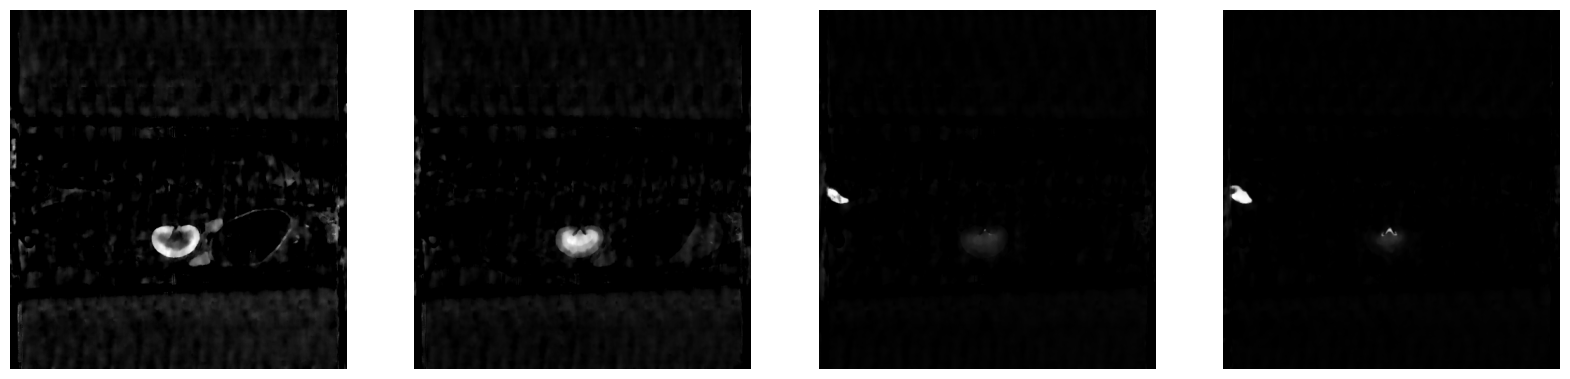

In [48]:
print(s1.acquisition[0].conventional.shape)

import matplotlib.pyplot as plt
n = 300

plt.figure(figsize=(20, 10))
plt.subplot(1,4,1)
plt.imshow(s1.acquisition[0].kedge[n,:,:], cmap = 'gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(s1.acquisition[1].kedge[n,:,:], cmap = 'gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(s1.acquisition[2].kedge[n,:,:], cmap = 'gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(s1.acquisition[3].kedge[n,:,:], cmap = 'gray')
plt.axis('off')

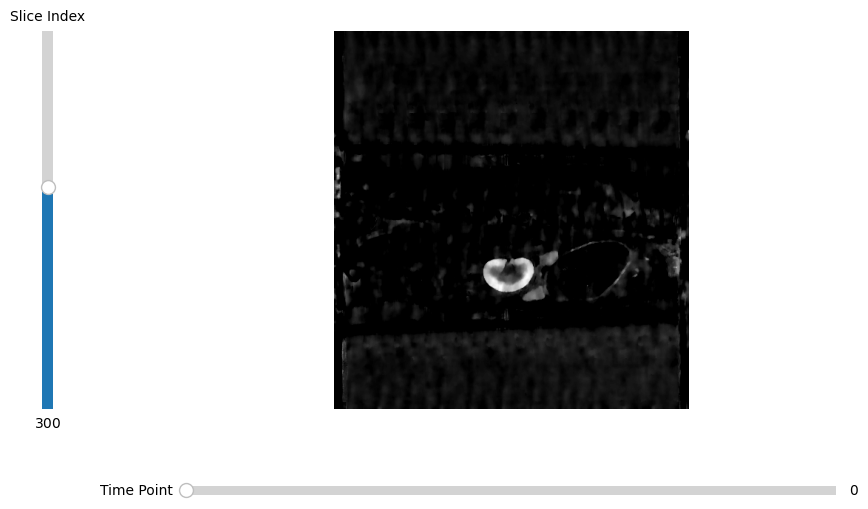

In [50]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Initial settings
init_time_point = 0  # Initial time point
init_slice_index = 300  # Initial slice index, ensure this is within the bounds of your stacks

# Prepare figure and axis for the image
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.25, bottom=0.25)

# Display initial image from the first time point and chosen slice
image_display = ax.imshow(s1.acquisition[init_time_point].kedge[init_slice_index, :, :], cmap='gray')
ax.axis('off')  # Hide axis

# Slider for selecting the time point
ax_time = plt.axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax_time, 'Time Point', 0, len(s1.acquisition)-1, valinit=init_time_point, valfmt='%0.0f')

# Slider for selecting the slice
ax_slice = plt.axes([0.1, 0.25, 0.0225, 0.63])
slice_slider = Slider(ax_slice, 'Slice Index', 0, s1.acquisition[0].kedge.shape[0]-1, valinit=init_slice_index, orientation='vertical')

def update(val):
    # Fetch the time point and slice index from the sliders
    time_point = int(time_slider.val)
    slice_index = int(slice_slider.val)
    # Update the displayed image based on the selected time point and slice index
    new_image = s1.acquisition[time_point].kedge[slice_index, :, :]
    image_display.set_data(new_image)
    fig.canvas.draw_idle()

# Register the update function with each slider
time_slider.on_changed(update)
slice_slider.on_changed(update)

plt.show()
